# Overview

The goal of this lab is to introduce you to camera and scene geometry. Specifically we will estimate the camera projection matrix, which maps 3D world coordinates to image coordinates, as well as the fundamental matrix, which relates points in one scene to epipolar lines in another. The camera projection matrix and the fundamental matrix can each be estimated using point correspondences. To estimate the projection matrix (camera calibration), the input is corresponding 3D and 2D points. To estimate the fundamental matrix the input is corresponding 2D points across two images. We start by estimating the projection matrix and the fundamental matrix for a scene with ground truth correspondences. Then we'll move on to estimating the fundamental matrix using point correspondences from SIFT. 

Tutorial on epipolar geometry is here: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html or here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

# Data

We provide 2D and 3D ground truth point correspondences for the base image pair (pic_a.jpg and pic_b.jpg), as well as other images which will not have any ground truth dataset.

<table width="950px">
<tr>
<th><center>Image 1 of a scene</center></th>
<th><center>Image 2 of a scene</center></th> 
</tr>
<tr>
<td><img src="data\pic_a.jpg" width=500 /></td>
<td><img src="data\pic_b.jpg" width=500 /></td>
</tr>
</table>   


This laboratory consists of three parts:
(1) estimating the projection matrix, 
(2) estimating the fundamental matrix,
(3) estimating the fundamental matrix with unreliable SIFT matches using RANSAC. 

# Part I: Camera Projection Matrix

The goal is to compute the projection matrix P that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation for moving from 3D world coordinates (a point has coordinates (X,Y,Z)) to 2D camera coordinates (a point has coordinates (u,v)) is: 

# $$\begin{pmatrix}u \\ v \\ 1\end{pmatrix} \cong \begin{pmatrix}u*s \\ v*s \\ s \end{pmatrix}= \begin{pmatrix}p_{11} & p_{12} & p_{13} & p_{14} \\ p_{21} & p_{22} & p_{23} & p_{24} \\ p_{31} & p_{32} & p_{33} & p_{34} \end{pmatrix} \begin{pmatrix}X \\ Y \\ Z \\ 1 \end{pmatrix} = P \begin{pmatrix}X \\ Y \\ Z \\ 1 \end{pmatrix}$$

Another way of writing this equation is: 

$$s = p_{31}X + p_{32}Y + p_{33}Z + p_{34}$$

$$p_{11}X + p_{12}Y + p_{13}Z + p_{14} - u*s = 0$$

$$p_{21}X + p_{22}Y + p_{23}Z + p_{24} - v*s = 0$$

We obtain that for each pair of corespondences between a 3D point in world coordinates $(X_i,Y_i,Z_i)$ and a 2D point in camera coordinates $(u_i,v_i)$ we have two equations:

$$p_{11}X_i + p_{12}Y_i + p_{13}Z_i + p_{14} - u_{i}p_{31}X_{i} - u_{i}p_{32}Y_{i} - u_{i}p_{33}Z_{i} - u_{i}p_{34} = 0$$

$$p_{21}X_i + p_{22}Y_i + p_{23}Z_i + p_{24} - v_{i}p_{31}X_{i} - v_{i}p_{32}Y_{i} - v_{i}p_{33}Z_{i} - v_{i}p_{34} = 0$$

We obtain a homogenous linear system of 2$\cdot \it{n}$ equations ($\it{n}$ is the number of points correspondences) that can be written as:

$$\begin{pmatrix} 
X_1 & Y_1 & Z_1 & 1 & 0   & 0   & 0   & 0 & -u_1X_1 & -u_1Y_1 & -u_1Z_1 & -u_1\\ 
0   & 0   & 0   & 0 & X_1 & Y_1 & Z_1 & 1 & -v_1X_1 & -v_1Y_1 & -v_1Z_1 & -v_1\\ 
\ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
X_n & Y_n & Z_n & 1 & 0   & 0   & 0   & 0 & -u_nX_n & -u_nY_n & -u_nZ_n & -u_n\\ 
0   & 0   & 0   & 0 & X_n & Y_n & Z_n & 1 & -v_nX_n & -v_nY_n & -v_nZ_n & -v_n 
\end{pmatrix}  \begin{pmatrix} p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\ p_{21} \\ p_{22} \\p_{23} \\ p_{24} \\ p_{31} \\ p_{32} \\ p_{33} \\ p_{34}\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \\0 \\ 0 \\ 0 \\0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix}$$

The homogenous linear system can be written more condensed as:

$$ \mathbf{Ap} = \mathbf{0}$$ 


In the above equation, the projection matrix $\mathbf{P}$ of dimensions $3 \times 4$ is written as the vector $\mathbf{p}$ of dimension $12 \times 1$. Reshaping the vector $\mathbf{p}$ will give you the projection matrix $\mathbf{P}$.

At this point, we are almost able to set up the linear regression to find the elements of the matrix $\mathbf{P}$. There's only one problem, the matrix $\mathbf{P}$ is only defined up to a scale (you can always multiple $\mathbf{P}$ by a constant $k$ and you will obtain the same result as all the components will be multiplied by $k$ and then we divide by the third component $s$ - see the above equation). So these equations have many different possible solutions, in particular $\mathbf{P}$ = all zeros is a solution which is not very helpful in our context. The way around this is to first fix a scale and then do the regression. There are several options for doing this:

(1) we can use the singular value decomposition to directly solve the constrained optimization problem:

$\begin{align*} &\min\|Ap \| \\ &s.t ~ \| p \| = 1\end{align*} $

In this case the solution is given by the eigenvector of the matrix $A$ corresponding to the smallest eigenvalue.

(2) we can fix the last element ($p_{34}$) to 1 and then find the remaining coefficients

In [1]:
import cv2 as cv 
import numpy as np
import math
import glob
from matplotlib import pyplot as plt

In [2]:
#load the normalized points (mean 0 and standard deviation small ~around 1)
points_2D = np.loadtxt('data/pts2d-norm-pic_a.txt')
number_points = points_2D.shape[0]
print(number_points)
points_3D = np.loadtxt('data/pts3d-norm.txt')
print(points_3D.shape[0])

20
20


In [3]:
def compute_projection_matrix(points_2D,points_3D,verbose=0):
    A = np.zeros((number_points*2,12))
    for j in range(number_points):
        u = points_2D[j,0]
        v = points_2D[j,1]
        X = points_3D[j,0]
        Y = points_3D[j,1]
        Z = points_3D[j,2]
        A[2*j,:] = [X,Y,Z,1,0,0,0,0,-u*X,-u*Y,-u*Z,-u]
        A[2*j+1,:] = [0,0,0,0,X,Y,Z,1,-v*X,-v*Y,-v*Z,-v]

    #do the SVD decomposition
    U, S, V = np.linalg.svd(A, full_matrices=True)
    
    #take the last eigenvector corresponding to the smallest eigenvalue
    p = V[-1]     
    
    #check that p is solution
    if verbose:
        print("Ap = ",A.dot(p))
        
    P = p.reshape((3,4))    
    return P

P = compute_projection_matrix(points_2D,points_3D,1)
print("P = ",P)
#check that the norm of P is 1
print(sum(sum(P**2)))

Ap =  [-1.34875061e-03  1.38477917e-03  6.16312681e-04  1.46866574e-03
 -7.89943756e-04 -3.54143912e-04 -5.71624383e-04 -5.86406962e-04
  4.83769064e-04  5.04094612e-04  5.37946690e-04 -6.59230362e-04
  3.10503963e-04 -2.14210333e-04  1.65297555e-04 -1.81508707e-03
 -9.00882241e-04 -1.01260884e-03  8.34651343e-05 -5.71818651e-04
  1.64779437e-03 -1.09197398e-03  6.95930372e-04  2.20803282e-04
  1.42387709e-03 -1.15879564e-03 -2.28239547e-04  5.28789233e-04
 -2.74003335e-03  3.34305450e-03  6.67442934e-04 -6.17312646e-04
 -3.85320894e-06  2.60798330e-04 -7.70029062e-04 -9.71062106e-04
 -5.43597970e-04  5.09315024e-04  1.26480204e-03  8.29907745e-04]
P =  [[ 0.45827554 -0.29474237 -0.01395746  0.0040258 ]
 [-0.05085589 -0.0545847  -0.54105993 -0.05237592]
 [ 0.10900958  0.17834548 -0.04426782  0.5968205 ]]
1.0


In [4]:
P_original = compute_projection_matrix(points_2D,points_3D,0)
print("P_original =",P_original)
#make P_34 = 1
print("P_scaled = ",P_original/P_original[2,3])

#another solution: take p34 =1, than Ap = b, where A has only 11 columns, p has only 11 components, b = [u1,v1,u2,v2,...]T
#Ax = b has solution x = (A^t*A)^(-1)*A^t*b, where A^t is A transpose and (A^t*A)^(-1) is the inverse of the matrix (A^t*A)

def compute_projection_matrix_fix_scale(points_2D,points_3D,verbose=0):
    A = np.zeros((number_points*2,11))
    b = np.zeros((number_points*2))
    for j in range(number_points):
        u = points_2D[j,0]
        v = points_2D[j,1]
        X = points_3D[j,0]
        Y = points_3D[j,1]
        Z = points_3D[j,2]
        A[2*j,:] = [X,Y,Z,1,0,0,0,0,-u*X,-u*Y,-u*Z]
        A[2*j+1,:] = [0,0,0,0,X,Y,Z,1,-v*X,-v*Y,-v*Z]
        b[2*j] = u
        b[2*j+1] = v
      
    
    p = (np.linalg.inv(A.transpose().dot(A))).dot(A.transpose()).dot(b)    
    
    if verbose:
        print("p =",p)
        print("P_scaled = ",P_original/P_original[2,3])    
        
    P = np.zeros(12)
    P[:11] = p.copy()
    P[11] = 1
    P = P.reshape((3,4))    
    return P

P = compute_projection_matrix_fix_scale(points_2D,points_3D,1)
print("P = ",P)

P_original = [[ 0.45827554 -0.29474237 -0.01395746  0.0040258 ]
 [-0.05085589 -0.0545847  -0.54105993 -0.05237592]
 [ 0.10900958  0.17834548 -0.04426782  0.5968205 ]]
P_scaled =  [[ 0.7678616  -0.4938543  -0.02338635  0.00674541]
 [-0.08521137 -0.09145916 -0.90657063 -0.08775825]
 [ 0.18265054  0.298826   -0.07417276  1.        ]]
p = [ 0.76785834 -0.49384797 -0.02339781  0.00674445 -0.0852134  -0.09146818
 -0.90652332 -0.08775678  0.18265016  0.29882917 -0.07419242]
P_scaled =  [[ 0.7678616  -0.4938543  -0.02338635  0.00674541]
 [-0.08521137 -0.09145916 -0.90657063 -0.08775825]
 [ 0.18265054  0.298826   -0.07417276  1.        ]]
P =  [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]


Let''s do a check. We can compute the total "residual" between the projected 2d location of each 3d point and the actual location of that point in the 2d image. The residual is just the distance (square root of the sum of squared differences in u and v). This should be very small.

In [4]:
#compute projected points and residuals
def compute_projected_points_and_residuals(P,points_2D,points_3D,verbose=0):
    sum_residuals = 0
    number_points = points_2D.shape[0]
    projected_points = np.zeros((number_points,2))
    for j in range(number_points):
        u = points_2D[j,0]
        v = points_2D[j,1]
        X = points_3D[j,0]
        Y = points_3D[j,1]
        Z = points_3D[j,2]
        #project point (X,Y,Z) using P and obtain a ray
        projected_point = P.dot([X,Y,Z,1])
        projected_point_homogoneous = projected_point/projected_point[-1]
        if verbose:
            print("projected point in homogenous coordinates = ", projected_point_homogoneous)
            print("2d point in homogenous coordinates = ",[u,v,1])
        projected_points[j,:] = projected_point_homogoneous[:2]
        sum_residuals=sum_residuals+np.sqrt((projected_point_homogoneous[0] - u)**2+(projected_point_homogoneous[1] - v)**2)
    return projected_points, sum_residuals

projected_points, residuals = compute_projected_points_and_residuals(P,points_2D,points_3D,0)
print("residuals = ", residuals)

residuals =  0.044548941765576396


 Once we have an accurate projection matrix $\mathbf{P}$, it is possible to tease it apart into the more familiar and more useful matrix $\mathbf{K}$ of intrinsic parameters and matrix $\mathbf{[R | T]}$ of extrinsic parameters. 
 
 We do know that:
 $$ \mathbf{P} = \mathbf{K}\mathbf{[R | t]} $$
 
For this lab exercise we will estimate one particular extrinsic parameter: the camera center in world coordinates. Let us define $\mathbf{P}$ as being made up of a $3 \times 3$ matrix that we will call Q and a 4th column will call $p_4$ :
$$ \mathbf{P} = \mathbf{[Q | p_4}]$$


The center of the camera $\mathbf{C}$ can be found by:
    $$ \mathbf{C} = \mathbf{-Q^{-1} p_4} $$



Camera center has coordinates =  [-1.51267725 -2.35168754  0.28262819]


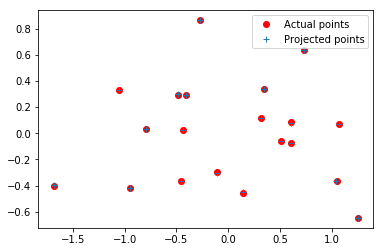

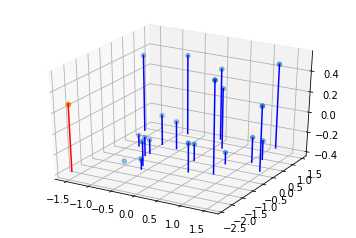

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_camera_center(P):
    Q = P[:3,:3]
    p4 = P[:,3]
    C = -np.linalg.inv(Q).dot(p4)
    return C


def visualize_points(actual_points, projected_points):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(actual_points[:,0],actual_points[:,1],'ro')
    ax.plot(projected_points[:,0],projected_points[:,1],'+')
    ax.legend(["Actual points", "Projected points"])

def plot_3d_view(points_3D,camera_center):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(points_3D[:,0], points_3D[:,1], points_3D[:,2], 'xg')
    
    #draw vertical lines connecting each point to Z=0    
    min_z = min(points_3D[:,2])
    for i in range(points_3D.shape[0]):
        ax.plot3D([points_3D[i,0],points_3D[i,0]], [points_3D[i,1], points_3D[i,1]], [points_3D[i,2],min_z], 'blue')

    #draw camera point    
    ax.scatter(camera_center[0],camera_center[1],camera_center[2],'or')        
    ax.plot3D([camera_center[0],camera_center[0]], [camera_center[1], camera_center[1]], [camera_center[2],min_z], 'red')

projected_points, residuals = compute_projected_points_and_residuals(P,points_2D,points_3D,0)
visualize_points(points_2D, projected_points)
C = compute_camera_center(P)
print("Camera center has coordinates = ", C)
plot_3d_view(points_3D,C)

# Part II: Fundamental Matrix Estimation

Tutorial on epipolar geometry is here: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html or here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

In the next part of this lab we estimate the mapping of points in one image to lines in another by means of the fundamental matrix. This requires using similar methods to those in part 1. We will make use of the corresponding point locations listed in pts2d-pic_a.txt and pts2d-pic_b.txt. Recall that the definition of the Fundamental Matrix is:

  $$  \begin{pmatrix}u' & v' & 1\end{pmatrix}\begin{pmatrix}f_{11} & f_{12} & f_{13} \\ f_{21} & f_{22} & f_{23} \\ f_{31} & f_{32} & f_{33} \end{pmatrix} \begin{pmatrix}u \\ v \\ 1\end{pmatrix} = 0. $$

where (u,v) and (u', v') are pairs of correspondence points in two images of the same scene.

Note: the fundamental matrix is sometimes defined as the transpose of the above matrix with the left and right image points swapped. Both are valid fundamental matrices, but the visualization functions should be change in this case.

Another way of writing this matrix equations is:

$$    \begin{pmatrix}u' & v' & 1\end{pmatrix}\begin{pmatrix}f_{11}u + f_{12}v + f_{13} \\ f_{21}u + f_{22}v + f_{23} \\ f_{31}u + f_{32}v + f_{33} \end{pmatrix} = 0 $$

Which is the same as:  $$ f_{11}uu' + f_{12}vu' + f_{13}u' + f_{21}uv' + f_{22}vv' + f_{23}v' + f_{31}u + f_{32}v + f_{33} = 0 $$

This equation resembles very much with the equations from part I. Given corresponding points you get one equation per point pair. With 8 or more points you can solve this (we cannot derive the scale parameter). As in part I there's an issue here where the matrix is only defined up to scale and the degenerate zero solution solves these equations. So we need to solve using the same method we used in part I of first fixing the scale and then solving the regression.

The least squares estimate of F is full rank; however, the fundamental matrix is a rank 2 matrix. As such we must reduce its rank. In order to do this we can decompose F using singular value decomposition into the matrices $U\Sigma V^T = F$. We can then estimate a rank 2 matrix by setting the smallest singular value in $\Sigma$ to zero thus generating $\Sigma_2$ . The fundamental matrix is then easily calculated as $F = U \Sigma_2 V^T$. We can check your fundamental matrix estimation by plotting the epipolar lines using the plotting function.

In [6]:
#read the images
img1  = cv.imread('data/pic_a.jpg') #right view
img2 = cv.imread('data/pic_b.jpg')  #left view

#load the points and draw them in the image
pts1 = np.loadtxt('data/pts2d-pic_a.txt')
pts2 = np.loadtxt('data/pts2d-pic_b.txt')

def draw_points_in_image(img,pts):
    img_ = img.copy()
    for i in range(pts.shape[0]):
        img_ = cv.circle(img_, (np.int64(pts[i,0]), np.int64(pts[i,1])), 2, [0,255,0], 4)
    return img_
        
img1_ = draw_points_in_image(img1,pts1)
img2_ = draw_points_in_image(img2,pts2)

cv.imshow("image_right",img1_)    
cv.imshow("image_left",img2_)
cv.waitKey(0)
cv.destroyAllWindows()                

In [10]:
#use the standard functions taken from the tuturial

#compute the fundamental matrix
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

print("F = ", F)

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,trash = img1.shape
    img1_ = img1.copy()
    img2_ = img2.copy()
    for r,pt1,pt2 in zip(lines,pts1,pts2):        
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1_ = cv.line(img1_, (x0,y0), (x1,y1), color,1)
        img1_ = cv.circle(img1_,tuple(np.int64(pt1)),5,color,-1)
        img2_ = cv.circle(img2_,tuple(np.int64(pt2)),5,color,-1)
    return img1_,img2_

# Find epilines corresponding to points in the left image and
# drawing its lines on right image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
cv.imshow("right view",img5)
cv.imshow("left view",img6)
cv.waitKey(0)
cv.destroyAllWindows()

# Find epilines corresponding to points in right image and
# drawing its lines on left image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

cv.imshow("left view",img3)
cv.imshow("right view",img4)
cv.waitKey(0)
cv.destroyAllWindows()

F_original = F.copy()

F =  [[ 6.92620948e-06 -9.36987765e-05  2.38357882e-02]
 [-1.47410734e-05  7.59895858e-05 -1.42046780e-01]
 [-8.27207871e-03  1.51735956e-01  1.00000000e+00]]


In [8]:
#derive manually the fundamental matrix without using the standard functions
#fix f_33 = 1
def compute_fundamental_matrix_fix_scale(points_a,points_b,verbose = 0):
    number_points = points_a.shape[0]
    A = np.zeros((number_points,8))
    b = np.zeros((number_points))
    for j in range(number_points):
        u_1 = points_a[j,0] #u
        v_1 = points_a[j,1] #v
        u_2 = points_b[j,0] #u'
        v_2 = points_b[j,1] #v'
        
        A[j,0] = u_1 * u_2
        A[j,1] = v_1 * u_2
        A[j,2] = u_2
        A[j,3] = u_1 * v_2
        A[j,4] = v_1 * v_2
        A[j,5] = v_2
        A[j,6] = u_1
        A[j,7] = v_1
        b[j] = -1
    
    f = (np.linalg.inv(A.transpose().dot(A))).dot(A.transpose()).dot(b)           
        
    F = np.zeros(9)
    F[:8] = f.copy()
    F[8] = 1
    F = F.reshape((3,3))  
    
    #make F to be of rank 2 by building Sigma_2 (put 0 to the smallest eignevalue)
    [U,S,V] = np.linalg.svd(F)
    S[2] = 0
    F = (U.dot(np.diag(S))).dot(V)    
    
    return F 


F = compute_fundamental_matrix_fix_scale(pts1,pts2,1)
print("current F = ", F)
#print("det F_original = ", np.linalg.det(F_original))
print("det F = ", np.linalg.det(F))

# Find epilines corresponding to points in the left image and
# drawing its lines on right image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
cv.imshow("right view",img5)
cv.imshow("left view",img6)
cv.waitKey(0)
cv.destroyAllWindows()

# Find epilines corresponding to points in right image and
# drawing its lines on left image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

cv.imshow("left view",img3)
cv.imshow("right view",img4)
cv.waitKey(0)
cv.destroyAllWindows()

current F =  [[-5.35883058e-07  7.89972529e-06 -1.88480998e-03]
 [ 8.83820595e-06  1.21802118e-06  1.72276843e-02]
 [-9.08539026e-04 -2.64201801e-02  1.00000000e+00]]
det F =  5.0393797848761544e-26


# Part III: Fundamental Matrix with RANSAC

For two photographs of a scene it's unlikely that you'd have perfect point corresponence with which to do the regression for the fundamental matrix. So, next you we going to compute the fundamental matrix with unreliable point correspondences computed with SIFT. Least squares regression is not appropriate in this scenario due to the presence of multiple outliers. In order to estimate the fundamental matrix from this noisy data we will need to use RANSAC in conjunction with the fundamental matrix estimation.

This is calculated from matching points from both the images. A minimum of 8 such points are required to find the fundamental matrix (while using 8-point algorithm). More points are preferred and use RANSAC to get a more robust result.

So first we need to find as many possible matches between two images to find the fundamental matrix. For this, we use SIFT descriptors with FLANN based matcher and ratio test.

We will first obtain SIFT correspondences (might not be reliable) for any image pair. We will use these initial point correspondences and RANSAC to find the "best" fundamental matrix. We will iteratively choose some number of point correspondences (8, 9, or some small number), solve for the fundamental matrix and then count the number of inliers. Inliers in this context will be point correspondences that "agree" with the estimated fundamental matrix. 

Our code will return the fundamental matrix with the most number of inliers.

In [16]:
def get_fundamental_matrix_using_sift(img1, img2):
    
    sift = cv.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    pts1 = []
    pts2 = []

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.array(pts1, dtype='float32')
    pts2 = np.array(pts2, dtype='float32')
    
    #use RANSAC, maximum allowed distance 3 pixels, with confidence 99% (repeat many times until you are sure)
    #documentation here: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC,3,0.99)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return F, pts1, pts2


In [ ]:
filename1 = "data/Mount Rushmore/7433804322_06c5620f13_o.jpg"
filename1 = "data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg"
filename1 = "data/Notre Dame/921919841_a30df938f2_o.jpg"
filename1 = "data/Woodruff Dorm/wood1.jpg"

filename2 = "data/Mount Rushmore/9193029855_2c85a50e91_o.jpg"
filename2 = "data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg"
filename2 = "data/Notre Dame/4191453057_c86028ce1f_o.jpg"
filename2 = "data/Woodruff Dorm/wood2.jpg"

img1 = cv.imread(filename1)
img1 = cv.resize(img1,(img1.shape[1]//4,img1.shape[0]//4))
print(img1.shape)
img2 = cv.imread(filename2)
img2 = cv.resize(img2,(img2.shape[1]//4,img2.shape[0]//4))
print(img2.shape)

F, pts1, pts2 = get_fundamental_matrix_using_sift(img1, img2)

# Find epilines corresponding to points in the left image and
# drawing its lines on right image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
cv.imshow("left view",img5)
cv.imshow("right view",img6)
cv.waitKey(0)
cv.destroyAllWindows()

# Find epilines corresponding to points in right image and
# drawing its lines on left image

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

cv.imshow("right view",img3)
cv.imshow("left view",img4)
cv.waitKey(0)
cv.destroyAllWindows()

(612, 816, 3)
(612, 816, 3)
